In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
df = pd.read_csv('transformed_sample.csv')
del df['Unnamed: 0']

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Unexpected error removal 

The following steps are used for unexpected strings removal in transformed data. The data coming out of data-transformer may suffer unexpected string inputs in some cells.

In [153]:
a=[]
b=[]
for i in range(len(df.columns)):
    for j in range(len(umap_df)):
        if type(umap_df.iloc[j,i]) == str:
            a.append(j)
            b.append(i)

In [1]:
for i in a:
    for j in b:
        try:
            df.iloc[i,j] = int(umap_df.iloc[i,j])
        except:
            df.iloc[i,j] = 3000 #set a large number as rank for exception

NameError: name 'a' is not defined

In [186]:
for ele in df.columns:
    if sum(np.isnan(df[ele])) > 0:
        np.nan_to_num(df[ele],0)

## PCA

In [178]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(umap_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [180]:
principal=pd.DataFrame(principalDf)
principal=pd.concat([principal,pd.Series(target)],1)

In [181]:
principal.columns=['first','second','affiliation']

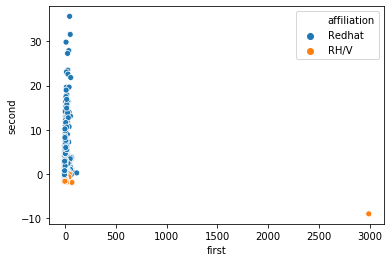

In [182]:
sns.scatterplot(x=principal['first'],y=principal['second'],hue=principal['affiliation'])

Datapoints are aggregated on the very left hand side. Then try standardizing.

In [189]:
from sklearn.preprocessing import StandardScaler
features = umap_df.columns
# Separating out the features
x = umap_df.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [190]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [191]:
principal=pd.DataFrame(principalDf)
principal=pd.concat([principal,pd.Series(target)],1)

In [192]:
principal.columns=['first','second','affiliation']

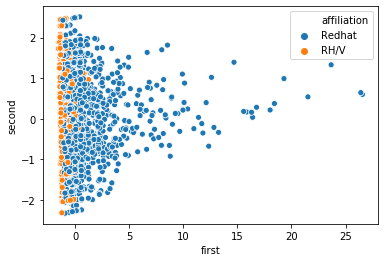

In [193]:
sns.scatterplot(x=principal['first'],y=principal['second'],hue=principal['affiliation'])

Try a 3-dimensional PCA to ensure we don't miss information on projection.

In [194]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [195]:
principal=pd.DataFrame(principalDf)
principal=pd.concat([principal,pd.Series(target)],1)

In [196]:
principal.columns=['first','second','third','affiliation']

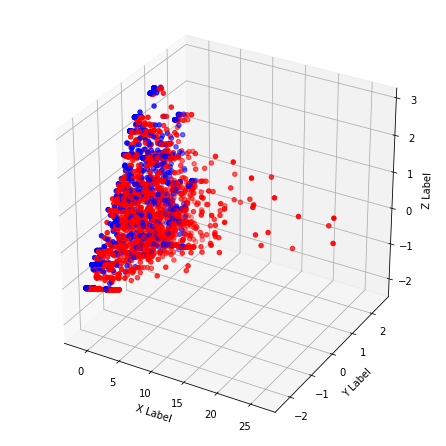

In [201]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = principal['first']
y = principal['second']
z = principal['third']
target=np.where(principal['affiliation']=='Redhat','red','blue')

ax.scatter(x, y, z, c=target, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

From both dimension reduction methods, we can both observe a potential clustering phenomena.

## Anomaly Dection using Isolation Forest (IF)
The idea is to detect anomaly by finding out the shortest average path in the tree. 

In [207]:
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
outliers_fraction = 0.01

In [216]:
# scale the data 
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(umap_df)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

/opt/app-root/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [221]:
principal=pd.concat([principal,df['anomaly25']],1)

In [222]:
principal.columns=['first','second','third','affiliation','anomaly25']

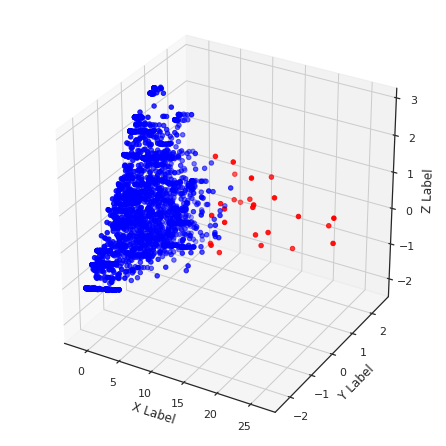

In [223]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = principal['first']
y = principal['second']
z = principal['third']
target=np.where(principal['anomaly25']==1,'red','blue')

ax.scatter(x, y, z, c=target, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()